In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn

In [2]:
from keras.datasets.fashion_mnist import load_data
(X_train, y_train), (X_test, y_test) = load_data()
X_train, X_valid = X_train[10_000:], X_train[:10000]
y_train, y_valid = y_train[10_000:], y_train[:10000]

print(f"""X_train: {X_train.shape}, y_train: {y_train.shape},
X_valid: {X_valid.shape}, y_valid: {y_valid.shape},
X_test: {X_test.shape}, y_test: {y_test.shape} """)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train: (50000, 28, 28), y_train: (50000,),
X_valid: (10000, 28, 28), y_valid: (10000,),
X_test: (10000, 28, 28), y_test: (10000,) 


In [3]:
X_train, X_valid, X_test = X_train/255.0, X_valid/255.0, X_test/255.0
X_train, X_valid, X_test = X_train.reshape((-1, 28, 28, 1)), X_valid.reshape((-1, 28, 28, 1)), X_test.reshape((-1, 28, 28, 1))

In [4]:
50000/256

195.3125

In [5]:
x = []
y = []
count = 0
for i in range(195):
    x.append(X_train[count:count+256])
    y.append(y_train[count:count+256])
    count += 256

# Baseline

In [7]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 4, activation = "relu", kernel_initializer = "he_normal", padding = "same", input_shape = [28, 28, 1]),
    keras.layers.Conv2D(64, 4, activation = "relu", kernel_initializer = "he_normal", padding = "same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation = "relu", kernel_initializer = "he_normal", padding = "same"),
    keras.layers.AveragePooling2D(2),
    keras.layers.Conv2D(128, 3, activation = "relu", kernel_initializer = "he_normal", padding = "same"),
    keras.layers.AveragePooling2D(2),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(10, activation = "softmax", kernel_initializer = "glorot_normal")
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 7, 7, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 3, 3, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,106 (1000.41 KB)

 Trainable params: 256,106 (1000.41 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def single_opt(model, epochs, optimizer, loss_fn, x, y, X_valid, y_valid, X_test, y_test):
    accuracies = []
    losses = []
    flag = False
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for x_, y_ in zip(x, y):
            with tf.GradientTape() as tape:
                logits = model(x_, training=True)
                loss = loss_fn(y_, logits)
            ####
            #if loss <= 0.001:
            #    flag = True
            ####
        
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        loss, acc = model.evaluate(X_valid, y_valid, verbose=0)
        losses.append(loss)
        accuracies.append(acc*100)
        print(f'Loss: {loss}, Accuracy: {acc*100}')
        #if flag == True:
        #    break

        
            # Evaluate the model
    results = model.evaluate(X_test, y_test, verbose=1)

    # Print the evaluation results
    print('Test loss:', results[0])
    print('Test accuracy:', results[1]*100)
    
    return model, losses, accuracies

## 1.1 SGD (lr = 0.009)

In [9]:
model_baseline = tf.keras.models.clone_model(model)
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.009)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model_baseline.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
model_sgd, losses_sgd, accuracies_sgd = single_opt(
    model_baseline, 20, optimizer, loss_fn, x, y, X_valid, y_valid, X_test, y_test
)
tf.keras.backend.clear_session()

Epoch 1/20


I0000 00:00:1724447985.748805     104 service.cc:145] XLA service 0x79af300043f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724447985.748844     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724447985.748848     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1724447986.525548     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Loss: 1.5353648662567139, Accuracy: 50.48999786376953
Epoch 2/20
Loss: 1.0905954837799072, Accuracy: 60.29999852180481
Epoch 3/20
Loss: 0.9169642329216003, Accuracy: 66.96000099182129
Epoch 4/20
Loss: 0.8364500999450684, Accuracy: 68.94000172615051
Epoch 5/20
Loss: 0.7825397253036499, Accuracy: 70.74999809265137
Epoch 6/20
Loss: 0.7488139271736145, Accuracy: 71.50999903678894
Epoch 7/20
Loss: 0.7220015525817871, Accuracy: 72.3800003528595
Epoch 8/20
Loss: 0.704912006855011, Accuracy: 72.75000214576721
Epoch 9/20
Loss: 0.6861838102340698, Accuracy: 73.61999750137329
Epoch 10/20
Loss: 0.6721168756484985, Accuracy: 73.83000254631042
Epoch 11/20
Loss: 0.6551575064659119, Accuracy: 74.70999956130981
Epoch 12/20
Loss: 0.650775134563446, Accuracy: 74.68000054359436
Epoch 13/20
Loss: 0.6358858346939087, Accuracy: 75.29000043869019
Epoch 14/20
Loss: 0.627082109451294, Accuracy: 75.5400002002716
Epoch 15/20
Loss: 0.6194694638252258, Accuracy: 76.010000705719
Epoch 16/20
Loss: 0.6122809648513794,

## 1.2 SGD + Momentum with nesterov = True (0.9) (lr = 0.009)

In [11]:
model_baseline = tf.keras.models.clone_model(model)
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.009, momentum = 0.9, nesterov = True)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model_baseline.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
model_nag, losses_nag, accuracies_nag = single_opt(
    model_baseline, 20, optimizer, loss_fn, x, y, X_valid, y_valid, X_test, y_test
)
tf.keras.backend.clear_session()

Epoch 1/20
Loss: 0.7319501638412476, Accuracy: 73.07000160217285
Epoch 2/20
Loss: 0.6284744739532471, Accuracy: 76.84999704360962
Epoch 3/20
Loss: 0.5755375623703003, Accuracy: 79.43999767303467
Epoch 4/20
Loss: 0.5422941446304321, Accuracy: 80.5899977684021
Epoch 5/20
Loss: 0.5105203986167908, Accuracy: 81.6100001335144
Epoch 6/20
Loss: 0.4820970594882965, Accuracy: 82.45999813079834
Epoch 7/20
Loss: 0.45810845494270325, Accuracy: 83.55000019073486
Epoch 8/20
Loss: 0.44931963086128235, Accuracy: 83.8699996471405
Epoch 9/20
Loss: 0.42853572964668274, Accuracy: 84.11999940872192
Epoch 10/20
Loss: 0.41337382793426514, Accuracy: 84.74000096321106
Epoch 11/20
Loss: 0.40322649478912354, Accuracy: 85.15999913215637
Epoch 12/20
Loss: 0.3874964714050293, Accuracy: 85.79000234603882
Epoch 13/20
Loss: 0.37690940499305725, Accuracy: 86.29000186920166
Epoch 14/20
Loss: 0.3738349974155426, Accuracy: 86.3099992275238
Epoch 15/20
Loss: 0.36225762963294983, Accuracy: 86.6100013256073
Epoch 16/20
Loss:

## 1.3 RMSprop (lr = 0.009)

In [13]:
model_baseline = tf.keras.models.clone_model(model)
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.009)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model_baseline.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
model_rmsprop, losses_rmsprop, accuracies_rmsprop = single_opt(
    model_baseline, 20, optimizer, loss_fn, x, y, X_valid, y_valid, X_test, y_test
)
tf.keras.backend.clear_session()

Epoch 1/20
Loss: 0.5669207572937012, Accuracy: 78.38000059127808
Epoch 2/20
Loss: 0.5960955023765564, Accuracy: 76.88999772071838
Epoch 3/20
Loss: 0.3460695743560791, Accuracy: 87.08999752998352
Epoch 4/20
Loss: 0.33829429745674133, Accuracy: 87.54000067710876
Epoch 5/20
Loss: 0.2970530688762665, Accuracy: 88.7399971485138
Epoch 6/20
Loss: 0.2581635117530823, Accuracy: 90.49999713897705
Epoch 7/20
Loss: 0.22823931276798248, Accuracy: 91.57999753952026
Epoch 8/20
Loss: 0.2457309514284134, Accuracy: 90.71999788284302
Epoch 9/20
Loss: 0.25441280007362366, Accuracy: 90.93000292778015
Epoch 10/20
Loss: 0.2465248554944992, Accuracy: 91.54999852180481
Epoch 11/20
Loss: 0.238379567861557, Accuracy: 91.75000190734863
Epoch 12/20
Loss: 0.23168928921222687, Accuracy: 92.0799970626831
Epoch 13/20
Loss: 0.22666200995445251, Accuracy: 92.1999990940094
Epoch 14/20
Loss: 0.2612897455692291, Accuracy: 91.38000011444092
Epoch 15/20
Loss: 0.24220027029514313, Accuracy: 91.93000197410583
Epoch 16/20
Loss:

## 1.4 Adagrad (lr = 0.009)

In [15]:
model_baseline = tf.keras.models.clone_model(model)
optimizer = tf.keras.optimizers.Adagrad(learning_rate = 0.009)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model_baseline.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
model_adagrad, losses_adagrad, accuracies_adagrad = single_opt(
    model_baseline, 20, optimizer, loss_fn, x, y, X_valid, y_valid, X_test, y_test
)
tf.keras.backend.clear_session()

Epoch 1/20
Loss: 1.1947262287139893, Accuracy: 55.01999855041504
Epoch 2/20
Loss: 0.9108218550682068, Accuracy: 65.93999862670898
Epoch 3/20
Loss: 0.7749053239822388, Accuracy: 70.81999778747559
Epoch 4/20
Loss: 0.7247411608695984, Accuracy: 72.49000072479248
Epoch 5/20
Loss: 0.7008073329925537, Accuracy: 73.21000099182129
Epoch 6/20
Loss: 0.6627269983291626, Accuracy: 74.37000274658203
Epoch 7/20
Loss: 0.6410651206970215, Accuracy: 75.26999711990356
Epoch 8/20
Loss: 0.6274756193161011, Accuracy: 75.94000101089478
Epoch 9/20
Loss: 0.6093946099281311, Accuracy: 76.66000127792358
Epoch 10/20
Loss: 0.5983160734176636, Accuracy: 76.99999809265137
Epoch 11/20
Loss: 0.5911810398101807, Accuracy: 77.13000178337097
Epoch 12/20
Loss: 0.5755066275596619, Accuracy: 78.07999849319458
Epoch 13/20
Loss: 0.5735167860984802, Accuracy: 77.81000137329102
Epoch 14/20
Loss: 0.5576760172843933, Accuracy: 78.86999845504761
Epoch 15/20
Loss: 0.5468446612358093, Accuracy: 79.39000129699707
Epoch 16/20
Loss: 0

## 1.5 Adam (lr = 0.009)

In [17]:
model_baseline = tf.keras.models.clone_model(model)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.009)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model_baseline.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
model_adam, losses_adam, accuracies_adam = single_opt(
    model_baseline, 20, optimizer, loss_fn, x, y, X_valid, y_valid, X_test, y_test
)
tf.keras.backend.clear_session()

Epoch 1/20
Loss: 0.5228032469749451, Accuracy: 82.02999830245972
Epoch 2/20
Loss: 0.3998037576675415, Accuracy: 85.71000099182129
Epoch 3/20
Loss: 0.34758391976356506, Accuracy: 87.0199978351593
Epoch 4/20
Loss: 0.34331411123275757, Accuracy: 87.52999901771545
Epoch 5/20
Loss: 0.29351961612701416, Accuracy: 89.03999924659729
Epoch 6/20
Loss: 0.28523772954940796, Accuracy: 89.42000269889832
Epoch 7/20
Loss: 0.29013824462890625, Accuracy: 88.99999856948853
Epoch 8/20
Loss: 0.24045343697071075, Accuracy: 91.28999710083008
Epoch 9/20
Loss: 0.24991725385189056, Accuracy: 90.86999893188477
Epoch 10/20
Loss: 0.24672333896160126, Accuracy: 90.92000126838684
Epoch 11/20
Loss: 0.24462495744228363, Accuracy: 90.829998254776
Epoch 12/20
Loss: 0.23873098194599152, Accuracy: 91.11999869346619
Epoch 13/20
Loss: 0.2435643970966339, Accuracy: 91.0099983215332
Epoch 14/20
Loss: 0.2318391650915146, Accuracy: 91.51999950408936
Epoch 15/20
Loss: 0.23667646944522858, Accuracy: 91.24000072479248
Epoch 16/20


# PGO

In [ ]:
def pgo(model, epochs, optimizer1, optimizer2, loss_fn, x, y, X_valid, y_valid, X_test, y_test):
    iter_count = 0
    loss_list = []
    acc_list = []
    flag = False

    with tf.GradientTape() as tape:
        logits2 = model(x[0], training=True)
        loss2 = loss_fn(y[0], logits2)
    grads2 = tape.gradient(loss2, model.trainable_weights)
    for epoch in range(epochs):
        print(f'Epoch: {epoch + 1} / {epochs}')
        for x_, y_ in zip(x, y):
            if iter_count % 2 ==0:
                with tf.GradientTape() as tape:
                    logits1 = model(x_, training = True)
                    loss1 = loss_fn(y_, logits1)
                grads1 = tape.gradient(loss1, model.trainable_weights)
            
                guidance1 = [(1 - tf.exp(-tf.abs(i))) for i in grads1]
            
                weighted_guidance1 = [i*loss1 for i in grads2]
                weighted_guidance1 = [
                    grads_*guidance_ for grads_, guidance_ in zip(grads2,guidance1)
                ]
            
                ####
                #ideal_grads = [tf.zeros_like(grad) for grad in grads1]
                #distance = [tf.norm(grad) for grad in grads1]
                #total_distance = tf.reduce_sum(distances)+1
            
                #weighted_guidance1 = [grad*total_distance for grad in grads1]
                ######
            
            
                optimizer1.apply_gradients(zip(grads1+weighted_guidance1, model.trainable_weights))
            
            
            else:
                with tf.GradientTape() as tape:
                    logits2 = model(x_, training = True)
                    loss2 = loss_fn(y_, logits2)
                grads2 = tape.gradient(loss2, model.trainable_weights)
                guidance2 = [(1 - tf.exp(-tf.abs(i))) for i in grads2]
            
                weighted_guidance2 = [i*loss2 for i in grads1]
                weighted_guidance2 = [
                    grads_*guidance_ for grads_, guidance_ in zip(grads1,guidance2)
                ]
            
                ####
                #ideal_grads = [tf.zeros_like(grad) for grad in grads2]
                #distance = [tf.norm(grad) for grad in grads2]
                #total_distance = tf.reduce_sum(distances)+1
            
                #weighted_guidance2 = [grad*total_distance for grad in grads2]
                ####
            
                optimizer2.apply_gradients(zip(grads2+weighted_guidance2, model.trainable_weights))
            
            iter_count += 1
        
            #if loss1 <= 0.001 or loss2 <= 0.001:
            #    flag = True
            
        
        loss, acc = model.evaluate(X_valid, y_valid, verbose = 0)
        loss_list.append(loss)
        acc_list.append(acc*100)
        print(f'Loss: {loss}, Accuracy: {acc}')
        
        #f flag == True:
        #   break      
        
    print(f"""acc1: {model.evaluate(X_test, y_test, verbose=1)}""")
        
    
    return model, loss_list, acc_list

## PGO (Adam 0.009, SGD 0.005)

In [30]:
tf.keras.backend.clear_session()

model_pgo = tf.keras.models.clone_model(model)

optimizer1 = tf.keras.optimizers.Adam(learning_rate = 0.0045) #Adam 0.005
optimizer2 = tf.keras.optimizers.SGD(learning_rate = 0.0045) #SGD 0.005

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model_pgo.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
model_pgo, losses_pgo, accuracies_pgo = pgo(
    model_pgo, 20, optimizer1, optimizer2, loss_fn, x, y, X_valid, y_valid, X_test, y_test
)
tf.keras.backend.clear_session()

Epoch: 1 / 20
Loss: 0.6186062693595886, Accuracy: 0.7633000016212463
Epoch: 2 / 20
Loss: 0.48315757513046265, Accuracy: 0.8228999972343445
Epoch: 3 / 20
Loss: 0.4405791461467743, Accuracy: 0.8402000069618225
Epoch: 4 / 20
Loss: 0.3837667405605316, Accuracy: 0.861299991607666
Epoch: 5 / 20
Loss: 0.35565614700317383, Accuracy: 0.8676999807357788
Epoch: 6 / 20
Loss: 0.33677294850349426, Accuracy: 0.8799999952316284
Epoch: 7 / 20
Loss: 0.31200894713401794, Accuracy: 0.8840000033378601
Epoch: 8 / 20
Loss: 0.312299519777298, Accuracy: 0.8852999806404114
Epoch: 9 / 20
Loss: 0.3195096552371979, Accuracy: 0.8804000020027161
Epoch: 10 / 20
Loss: 0.26951125264167786, Accuracy: 0.9049000144004822
Epoch: 11 / 20
Loss: 0.2640942335128784, Accuracy: 0.9036999940872192
Epoch: 12 / 20
Loss: 0.26169702410697937, Accuracy: 0.9070000052452087
Epoch: 13 / 20
Loss: 0.26397186517715454, Accuracy: 0.902899980545044
Epoch: 14 / 20
Loss: 0.2446570247411728, Accuracy: 0.9104999899864197
Epoch: 15 / 20
Loss: 0.24

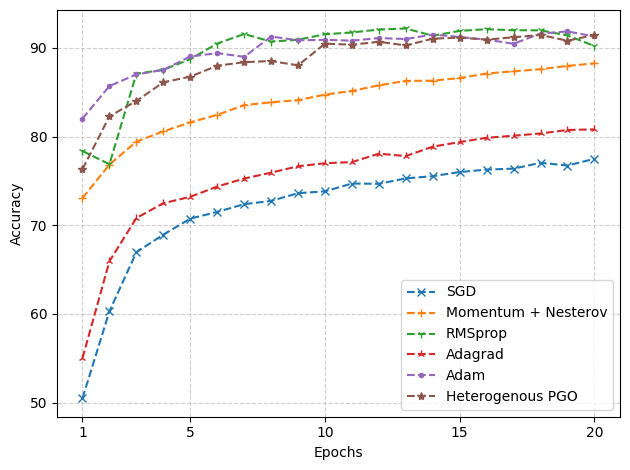

In [37]:
import matplotlib.pyplot as plt
epochs = range(1, len(accuracies_sgd) + 1)

plt.plot(epochs, accuracies_sgd, marker='x', linestyle='dashed', label='SGD')
plt.plot(epochs, accuracies_nag, marker='+', linestyle='dashed', label='Momentum + Nesterov')
plt.plot(epochs, accuracies_rmsprop, marker='1', linestyle='dashed', label='RMSprop')
plt.plot(epochs, accuracies_adagrad, marker='2', linestyle='dashed', label='Adagrad')
plt.plot(epochs, accuracies_adam, marker='.', linestyle='dashed', label='Adam')
plt.plot(epochs, accuracies_pgo, marker='*', linestyle='dashed', label='Heterogenous PGO')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best', fontsize=10)
tick_positions = [1, 5, 10, 15, 20]
plt.xticks(tick_positions)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.legend()
plt.show()

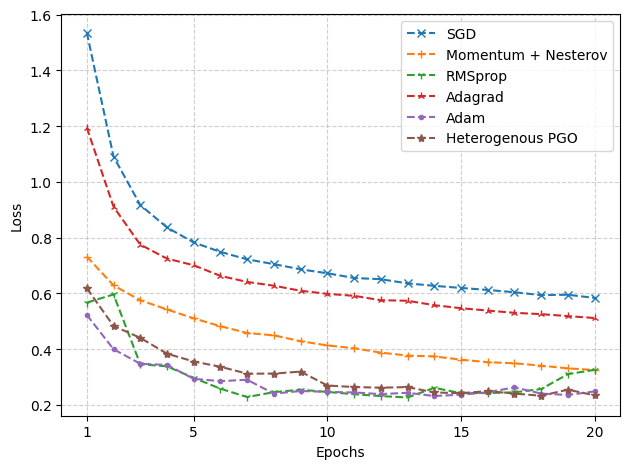

In [38]:
epochs = range(1, len(accuracies_sgd) + 1)

plt.plot(epochs, losses_sgd, marker='x', linestyle='dashed', label='SGD')
plt.plot(epochs, losses_nag, marker='+', linestyle='dashed', label='Momentum + Nesterov')
plt.plot(epochs, losses_rmsprop, marker='1', linestyle='dashed', label='RMSprop')
plt.plot(epochs, losses_adagrad, marker='2', linestyle='dashed', label='Adagrad')
plt.plot(epochs, losses_adam, marker='.', linestyle='dashed', label='Adam')
plt.plot(epochs, losses_pgo, marker='*', linestyle='dashed', label='Heterogenous PGO')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best', fontsize=10)
tick_positions = [1, 5, 10, 15, 20]
plt.xticks(tick_positions)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.legend()
plt.show()

In [39]:
losses = np.array([losses_sgd,
                  losses_nag,
                  losses_rmsprop,
                  losses_adagrad,
                  losses_adam,
                  losses_pgo])
np.save('losses_fashionmnist.npy', losses)

In [40]:
accuracies = np.array([accuracies_sgd,
                  accuracies_nag,
                  accuracies_rmsprop,
                  accuracies_adagrad,
                  accuracies_adam,
                  accuracies_pgo])
np.save('accuracies_fashionmnist.npy', accuracies)